In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import MinMaxScaler
import random
random.seed(0)
tf.random.set_seed(0)
np.random.seed(0)

## **Load the Data**

In [2]:
from keras.datasets import mnist
def load_data():
  (X_train, y_train), (X_test, y_test) = mnist.load_data()
  X_train = X_train.reshape(X_train.shape[0], -1)
  X_test = X_test.reshape(X_test.shape[0], -1)
  return (X_train, y_train), (X_test, y_test)

In [3]:
(X_train, y_train), (X_test, y_test) = load_data()

11490434/11490434 [==============================] - 0s 0us/step


In [4]:
from sklearn.decomposition import NMF
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
def preprocess_data(data):
  scaler = StandardScaler()
  data_std = scaler.fit_transform(data)
  n_components = 30
  pca = PCA(n_components=n_components)
  data_pca = pca.fit_transform(data_std)
  return data_pca

In [5]:
X_train = preprocess_data(X_train)
X_test = preprocess_data(X_test)

In [6]:
train_data_0 = pd.DataFrame(X_train[y_train == 0])
train_data_1 = pd.DataFrame(X_train[y_train == 1])[:3000]
train_data = pd.DataFrame(pd.concat([train_data_0,train_data_1]))
train = train_data.reset_index(drop = True)

train_label_0 = pd.DataFrame(y_train[y_train == 0])
train_label_1 = pd.DataFrame(y_train[y_train == 1])[:3000]
train_data_label = pd.DataFrame(pd.concat([train_label_0,train_label_1]))
y_train = train_data_label.reset_index(drop = True)

In [7]:
test_data_0 = pd.DataFrame(X_test[y_test.flatten() == 0])
test_data_1 = pd.DataFrame(X_test[y_test.flatten() == 1])[:500]
test_data = pd.DataFrame(pd.concat([test_data_0,test_data_1]))
test = test_data.reset_index(drop = True)

test_label_0 = pd.DataFrame(y_test[y_test == 0])
test_label_1 = pd.DataFrame(y_test[y_test == 1])[:500]
test_data_label = pd.DataFrame(pd.concat([test_label_0,test_label_1]))
y_test = test_data_label.reset_index(drop = True)

In [8]:
scaler = MinMaxScaler()
train = scaler.fit_transform(train)
train = np.array(train)
train = train / train.sum(axis=1, keepdims=True)
train = np.clip(train,0.0000005,None)

In [9]:
scaler = MinMaxScaler()
test = scaler.fit_transform(test)
test = np.array(test)
test = test / test.sum(axis=1, keepdims=True)
test = np.clip(test,0.0000005,None)

## **Expectation Step**

In [10]:
from scipy.special import gamma, digamma, gammaln, psi,polygamma
def log_dir(row,alphas):
  log_dir = []
  for alpha in alphas:
    q = gammaln(np.sum(alpha)) - np.sum(gammaln(alpha)) + np.sum((alpha-1)*np.log(row))
    log_dir.append(q)
  return np.array(log_dir)

In [11]:
def expectation_step(data, alphas, P,number_of_clusters):
    Z = np.zeros((len(data), number_of_clusters))

    for i, row in enumerate(data):
        log_posteriors = np.log(P) + log_dir(row, alphas)
        log_posteriors -= np.max(log_posteriors)
        posteriors = np.exp(log_posteriors)
        Z[i] = posteriors / np.sum(posteriors)
    return Z

## **Maximization Step** ##

In [12]:
def update_P(Z):
  return np.mean(Z,axis=0)

In [13]:
def normalize_alpha(arr, m, M):
    min_val = min(arr)
    max_val = max(arr)
    normalized_arr = []

    for value in arr:
        normalized_value = m + ((value - min_val) * (M - m) / (max_val - min_val))
        normalized_arr.append(normalized_value)

    return normalized_arr

In [14]:
def calcul_inv_hess_vect(data,alpha,Z,number_of_clusters):
  ((N, K),M) = (data.shape,number_of_clusters)
  Z_mean = np.clip(np.mean(Z,axis=0),10**(-15),None)
  inv_hess_vect_matrices = []
  for j in range(M):
    alpha_j = alpha[j]
    S = np.diag([-1/np.clip(float(polygamma(1,alpha_j[m]))*N*Z_mean[j],10**(-7),None) for m in range(K)])
    a_T = np.array([[-1/np.clip(float(polygamma(1,alpha_j[m]))*N*Z_mean[j],10**(-7),None) for m in range(K)]])
    gamma_et = float(polygamma(1,np.sum(alpha_j)))*N*Z_mean[j] / (1+float(polygamma(1,np.sum(alpha_j)))*N*Z_mean[j]*np.sum([-1/np.clip(float(polygamma(1,alpha_j[m]))*N*Z_mean[j],10**(-7),None) for m in range(K)]))
    H_inv = S + gamma_et*np.dot(a_T.T,a_T)
    inv_hess_vect_matrices.append(H_inv)
  return inv_hess_vect_matrices

In [15]:
def derivative(data,alpha_old,Z,number_of_clusters):
  ((N, K),M) = (data.shape,number_of_clusters)
  Z_mean = np.mean(Z,axis=0)
  der_param = []
  for j in range(M):
    der_vect_alpha_j = np.zeros(K)
    alpha_old_j = alpha_old[j]
    for s in range(K):
      der_vect_alpha_j[s] =N*Z_mean[j]*(psi(np.sum(alpha_old_j)) - psi(alpha_old_j[s])) - np.sum( Z[:,j]*np.log(data[:,s]) )
    der_param.append(der_vect_alpha_j)
  return der_param

In [16]:
def update_alpha(data,alpha_old,Z,number_of_clusters):
  M = number_of_clusters
  inv_hess = calcul_inv_hess_vect(data,alpha_old,Z,number_of_clusters)
  der_param = derivative(data,alpha_old,Z,number_of_clusters)
  alpha_new = []
  for j in range(M):
    (alpha_old_j,der_param_j,Hess_j) = (alpha_old[j],der_param[j],inv_hess[j])
    alpha_new_j = alpha_old_j - np.dot(Hess_j,der_param_j)
    alpha_new.append(np.array(normalize_alpha(np.array(alpha_new_j),0.1,10)))
  return alpha_new

In [17]:
alpha_zero = [np.array([2.83699713, 8.90793633, 2.91145545, 9.78488794, 0.39986101,
       0.75646506, 8.56591398, 6.18231114, 8.19241255, 7.12405629,
       7.4957519 , 7.78160211, 7.06654584, 1.25239824, 3.40538077,
       6.87667279, 4.52332325, 1.39414068, 6.42950045, 1.84507117,
       7.50037041, 3.83416578, 7.06781117, 9.36777392, 9.91538708,
       5.62187816, 5.98234897, 4.58319144, 6.03546566, 2.79246438]), np.array([9.61416972, 0.53016302, 7.29331948, 2.09039658, 2.52951919,
       1.91314876, 9.13740911, 6.40549748, 8.87753576, 8.74792981,
       0.34651668, 6.87464965, 8.69733948, 2.03154095, 4.12306459,
       1.63175595, 1.55008385, 4.15201794, 1.8705932 , 8.03504606,
       6.35972663, 8.23404961, 2.55201482, 4.00419629, 9.46879555,
       6.99329146, 2.95081735, 8.96305394, 1.83079042, 9.72406444])]

In [18]:
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score, confusion_matrix, accuracy_score
from sklearn import metrics

x_train_task = train
x_test_task = test

#EM Algorithm
M = 2
P = [0.2, 0.8]
alpha_old = alpha_zero
max_iter = 3
for iteration in range(max_iter):
  Z = expectation_step(x_train_task,alpha_old,P,M)
  alpha_new = update_alpha(x_train_task,alpha_old,Z,M)
  P = np.clip(update_P(Z),10**(-15),None)
  print('P=',P)
  alpha_old = alpha_new

P= [0.87677225 0.12322775]
P= [0.74320141 0.25679859]
P= [0.94552918 0.05447082]


In [19]:
print('alpha_zero',alpha_zero)
print('P=',P)
print('alpha',alpha_new)

alpha_zero [array([2.83699713, 8.90793633, 2.91145545, 9.78488794, 0.39986101,
       0.75646506, 8.56591398, 6.18231114, 8.19241255, 7.12405629,
       7.4957519 , 7.78160211, 7.06654584, 1.25239824, 3.40538077,
       6.87667279, 4.52332325, 1.39414068, 6.42950045, 1.84507117,
       7.50037041, 3.83416578, 7.06781117, 9.36777392, 9.91538708,
       5.62187816, 5.98234897, 4.58319144, 6.03546566, 2.79246438]), array([9.61416972, 0.53016302, 7.29331948, 2.09039658, 2.52951919,
       1.91314876, 9.13740911, 6.40549748, 8.87753576, 8.74792981,
       0.34651668, 6.87464965, 8.69733948, 2.03154095, 4.12306459,
       1.63175595, 1.55008385, 4.15201794, 1.8705932 , 8.03504606,
       6.35972663, 8.23404961, 2.55201482, 4.00419629, 9.46879555,
       6.99329146, 2.95081735, 8.96305394, 1.83079042, 9.72406444])]
P= [0.94552918 0.05447082]
alpha [array([ 7.87960672,  0.8580935 ,  7.74590283,  0.1       , 10.        ,
        9.8491673 ,  1.16940342,  3.94713314,  1.5735222 ,  2.85153916,
  

In [20]:
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score, confusion_matrix, accuracy_score
from sklearn import metrics

predictions_bin = []
for row in x_test_task:
      log_posteriors = np.exp(np.log(P)+log_dir(row,alpha_new))
      predicted_label = np.argmin(log_posteriors)
      predictions_bin.append(predicted_label)
predictions_bin = np.asarray(predictions_bin)
labels = np.array(y_test).flatten() == 0
f1 = f1_score(labels, predictions_bin)
precision = precision_score(labels, predictions_bin)
recall = recall_score(labels, predictions_bin)
acc = accuracy_score(labels, predictions_bin)

print("Accuracy:", acc)
print("F1 score:", f1)
print("Precision:", precision)
print("Recall:", recall)

Accuracy: 0.9027027027027027
F1 score: 0.9240506329113924
Precision: 0.9563318777292577
Recall: 0.8938775510204081


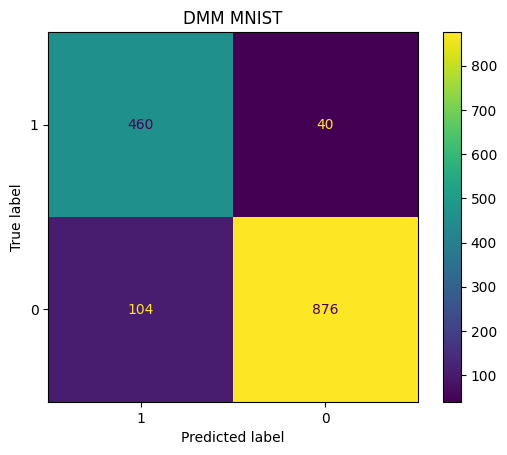

In [21]:
cm = confusion_matrix(labels, predictions_bin)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = ['1', '0'])
cm_display.plot()
cm_display.ax_.set_title('DMM MNIST')
plt.show()